In [1]:
import os
from data_loader.calib.intrinsic_extrinsic_loader import IntrinsicExtrinsicLoader
from data_loader.file_loader import FileLoader
from data_loader.file_writer import FileWriter
from tools.utils import *

platform = 'vehicle'
sequence_name = 'vehicle_campus00'
algorithm = 'fastlio2'

Finish loading parameters
Finish creating Folder
['body_imu', 'ouster00']
['body_imu', 'ouster00', 'ouster00_imu']
['body_imu', 'event_cam00']
['body_imu', 'event_cam01']
['body_imu', 'frame_cam00']
['body_imu', 'frame_cam01']
['body_imu', 'vehicle_frame_cam00']
['body_imu', 'vehicle_frame_cam01']


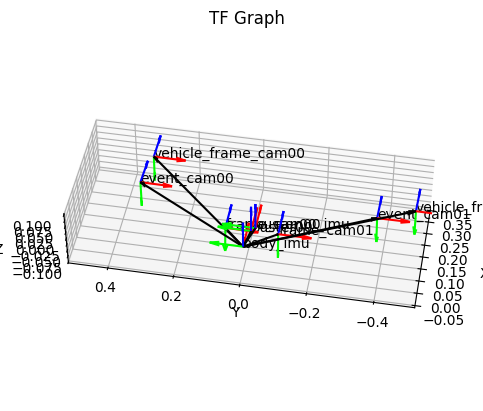

In [2]:
##### Set up the output data path
dataset_path = '/Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined'
calib_path = os.path.join(dataset_path, '../../calibration_files/20230618_calib/calib')
kitti360_path = os.path.join(dataset_path, sequence_name, 'kitti360')

##### Set up the message topic list for different platforms
# Platform
if platform == 'handheld':
  from cfg.dataset.cfg_handheld import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_handheld import dataset_rostopic_msg_frameid_dict
elif platform == 'ugv':
  from cfg.dataset.cfg_ugv import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_ugv import dataset_rostopic_msg_frameid_dict
elif platform == 'legged':
  from cfg.dataset.cfg_legged import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_legged import dataset_rostopic_msg_frameid_dict
  if sequence_name == 'legged_grass00':
    dataset_sensor_frameid_dict, dataset_rostopic_msg_frameid_dict = \
      filter_sensor('event', dataset_sensor_frameid_dict, dataset_rostopic_msg_frameid_dict)
elif platform =='vehicle':
  from cfg.dataset.cfg_vehicle import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_vehicle import dataset_rostopic_msg_frameid_dict
# Algorithm
if algorithm == 'r3live':
  from cfg.algorithm.cfg_r3live import algorithm_rostopic_msg_frameid_dict
elif algorithm == 'fastlio2':
  from cfg.algorithm.cfg_fastlio2 import algorithm_rostopic_msg_frameid_dict

##### Set up the sensor configuration
int_ext_loader = IntrinsicExtrinsicLoader(is_print=False)
int_ext_loader.load_calibration(calib_path=calib_path, sensor_frameid_dict=dataset_sensor_frameid_dict)
print('Finish loading parameters')

data_path = os.path.join(dataset_path, sequence_name, 'raw_data')
alg_result_path = os.path.join(dataset_path, sequence_name, 'algorithm_result')
file_loader = FileLoader()
file_writer = FileWriter()

##### Create the output data path
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'calibration'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'ouster00_undistort/points/data'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'ouster00/points/data'))
if platform == 'vehicle':
  flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'vehicle_frame_cam00/image/data'))
  flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'vehicle_frame_cam01/image/data'))
else:
  flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'frame_cam00/image/data'))
  flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'frame_cam01/image/data'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'event_cam00/image/data'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'event_cam01/image/data'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'odometry_alg'))
flag = os.system('mkdir -p '+ os.path.join(kitti360_path, 'camera_odometry_alg'))
print('Finish creating Folder')

##### Visualize TF-tree
int_ext_loader.tf_graph.visualize_graph()

In [3]:
##### Save calibration files according to KITTI format
calib_file_path = os.path.join(kitti360_path, 'calibration', 'perspective.txt')
file_writer.write_kitti_calibration_camera_intrinsics(platform, int_ext_loader, calib_file_path)
calib_file_path = os.path.join(kitti360_path, 'calibration', 'calib_cam_to_pose.txt')
file_writer.write_kitti_calibration_camera_extrinsics(platform, int_ext_loader, calib_file_path)

['vehicle_frame_cam00']
['vehicle_frame_cam01', 'vehicle_frame_cam00']
['event_cam00', 'ouster00', 'vehicle_frame_cam00']
['event_cam01', 'body_imu', 'vehicle_frame_cam00']
['body_imu', 'vehicle_frame_cam00']
['body_imu', 'vehicle_frame_cam01']
['body_imu', 'event_cam00']
['body_imu', 'event_cam01']


In [4]:
##### Parameters
t_add = 0.1 # the timestamp of the ouster00_undistorted is at the time of the last point approximate to 0.08s

##### Load timestamp from alg_result
# Ouster
if 'ouster_points' in dataset_rostopic_msg_frameid_dict.keys():
  ouster_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'ouster00/points/timestamps.txt')) 
  print('Loading ouster_timestamps: {}'.format(len(ouster_timestamps)))

##### Load timestamp from raw_data
# Ouster_undistort at the ouster00 frame
if 'ouster_points_undistorted' in algorithm_rostopic_msg_frameid_dict.keys():
  ouster_un_timestamps = file_loader.load_timestamp(os.path.join(alg_result_path, 'ouster00_undistort/points/timestamps.txt'))
  print('Loading ouster_un_timestamps: {}'.format(len(ouster_un_timestamps)))

# Frame_camera
if platform =='vehicle':
  if 'vehicle_frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam00/image/timestamps.txt'))
    print('Loading vehicle_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'vehicle_frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam01/image/timestamps.txt'))
    print('Loading vehicle_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
else:
  if 'frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam00/image/timestamps.txt'))
    print('Loading frame_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam01/image/timestamps.txt'))
    print('Loading frame_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
    
# Event Camera
if 'event_left_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam00/image/timestamps.txt'))
  print('Loading event_left_timestamps: {}'.format(len(event_left_image_timestamps)))
else:
  event_left_image_timestamps = []
if 'event_right_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam01/image/timestamps.txt'))
  print('Loading event_right_timestamps: {}'.format(len(event_right_image_timestamps)))
else:
  event_right_image_timestamps = []

if 'odometry' in algorithm_rostopic_msg_frameid_dict.keys():
  odom_timestamps, odom_quats, odom_trans = file_loader.load_odometry(os.path.join(alg_result_path, 'odometry/odometry.txt'), traj_type='TUM')
  print('Loading odom_timestamps: {}'.format(len(odom_timestamps)))

if 'camera_odometry' in algorithm_rostopic_msg_frameid_dict.keys():
  camodom_timestamps, camodom_quats, camodom_trans = file_loader.load_odometry(os.path.join(alg_result_path, 'camera_odometry/odometry.txt'), traj_type='TUM')
  print('Loading camodom_timestamps: {}'.format(len(camodom_timestamps)))

##### Match synchronized timestamps
th_ouster_ousterun = 0.02
th_ouster_fc, th_fl_fr = 0.03, 0.03
th_ouster_ec, th_el_er = 0.05, 0.05
matched_id_ouster_sensors_odom = []
for id, time in enumerate(ouster_timestamps):
  # Check Ouster_undistorted
  ouster_un_time, ousterun_id = find_closest_element_sorted(ouster_un_timestamps, time + t_add)
  if abs(time + t_add - ouster_un_time) < th_ouster_ousterun:
    # Check Odom
    odom_time, odom_id = find_closest_element_sorted(odom_timestamps, time)
    if abs(time - odom_time) < th_ouster_ousterun:
      # Check Frame Camera
      fl_time, fl_id = find_closest_element_sorted(frame_left_image_timestamps, time)
      fr_time, fr_id = find_closest_element_sorted(frame_right_image_timestamps, time)
      if abs(time - fl_time) < th_ouster_fc and abs(time - fr_time) < th_ouster_fc and abs(fl_time - fr_time) < th_fl_fr:
        # Check Event Camera
        el_time, el_id = find_closest_element_sorted(event_left_image_timestamps, time)
        er_time, er_id = find_closest_element_sorted(event_right_image_timestamps, time)
        if el_time is not None and er_time is not None:
          if abs(time - el_time) < th_ouster_fc and abs(time - er_time) < th_ouster_fc and abs(el_time - er_time) < th_el_er:
            matched_id_ouster_sensors_odom.append([id, ousterun_id, odom_id, fl_id, fr_id, el_id, er_id])
        else:
          matched_id_ouster_sensors_odom.append([id, ousterun_id, odom_id, fl_id, fr_id])
print('Length of matched id (ouster_un - sensors): {}'.format(len(matched_id_ouster_sensors_odom)))

Loading ouster_timestamps: 6111
Loading ouster_un_timestamps: 6106
Loading vehicle_left_timestamps: 12220
Loading vehicle_right_timestamps: 12220
Loading event_left_timestamps: 12220
Loading event_right_timestamps: 12220
Loading odom_timestamps: 6106
Length of matched id (ouster_un - sensors): 6057


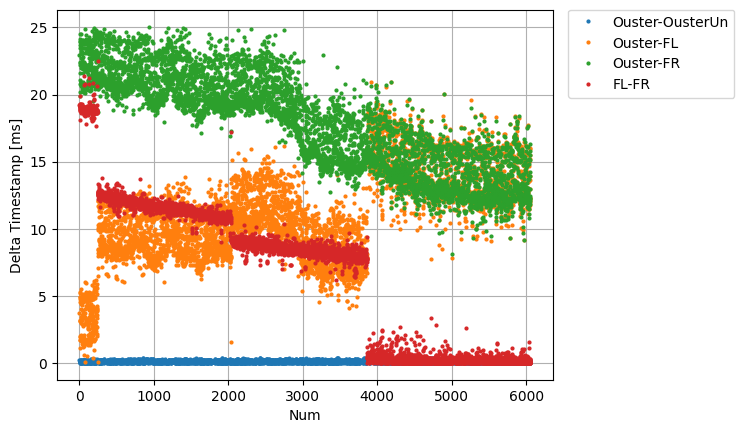

In [5]:
##### Analyze matched timestamps
if len(matched_id_ouster_sensors_odom) > 0:
  import matplotlib.pyplot as plt
  num = [i for i in range(0, len(matched_id_ouster_sensors_odom))]
  ##### Ouster_undistorted
  dt_ouster_ousterun = [1e3 * abs(ouster_timestamps[mid[0]] + t_add - ouster_un_timestamps[mid[1]]) for mid in matched_id_ouster_sensors_odom]
  plt.plot(num, dt_ouster_ousterun, label='Ouster-OusterUn', marker='o', markersize=2, linestyle='none')
  ##### Odometry
  # dt_ouster_odo = [1e3 * abs(ouster_timestamps[mid[0]] - odom_timestamps[mid[2]]) for mid in matched_id_ouster_sensors_odom]
  # plt.plot(num, dt_ouster_odo, label='Ouster-odo', marker='o', markersize=2, linestyle='none') 
  ##### Frame camera
  dt_ouster_fl = [1e3 * abs(ouster_timestamps[mid[0]] - frame_left_image_timestamps[mid[3]]) for mid in matched_id_ouster_sensors_odom]
  plt.plot(num, dt_ouster_fl, label='Ouster-FL', marker='o', markersize=2, linestyle='none')
  dt_ouster_fr = [1e3 * abs(ouster_timestamps[mid[0]] - frame_right_image_timestamps[mid[4]]) for mid in matched_id_ouster_sensors_odom]
  plt.plot(num, dt_ouster_fr, label='Ouster-FR', marker='o', markersize=2, linestyle='none')
  dt_fl_fr = [1e3 * abs(frame_left_image_timestamps[mid[3]] - frame_right_image_timestamps[mid[4]]) for mid in matched_id_ouster_sensors_odom]
  plt.plot(num, dt_fl_fr, label='FL-FR', marker='o', markersize=2, linestyle='none')
  ##### Event camera
  # if len(matched_id_ouster_sensors_odom[0]) == 7:
  #   dt_ouster_el = [1e3 * abs(ouster_timestamps[mid[0]] - event_left_image_timestamps[mid[5]]) for mid in matched_id_ouster_sensors_odom]
  #   plt.plot(num, dt_ouster_el, label='Ouster-EL', marker='*', markersize=2, linestyle='none')
  #   dt_ouster_er = [1e3 * abs(ouster_timestamps[mid[0]] - event_right_image_timestamps[mid[6]]) for mid in matched_id_ouster_sensors_odom]
  #   plt.plot(num, dt_ouster_er, label='Ouster-Er', marker='*', markersize=2, linestyle='none')
  #   dt_el_er = [1e3 * abs(event_left_image_timestamps[mid[5]] - event_right_image_timestamps[mid[6]]) for mid in matched_id_ouster_sensors_odom]
  #   plt.plot(num, dt_el_er, label='EL-ER', marker='d', markersize=2, linestyle='none')

  plt.xlabel('Num') 
  plt.ylabel('Delta Timestamp [ms]')
  plt.legend(loc='upper right', bbox_to_anchor=(1.38, 1.02))
  plt.grid(True)  
  plt.show()

In [6]:
##### Writing sensor data to files

def rewrite_undistort_image(old_path, new_path, camera):
  import cv2
  img = cv2.imread(old_path)
  undistorted_img = camera.undistort(img)
  cv2.imwrite(new_path, undistorted_img)

##### Save timestamps
select_time = [ouster_timestamps[mid[0]] for mid in matched_id_ouster_sensors_odom]
file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'ouster00/points/timestamps.txt'))
# Ouster_undistorted
select_time = [ouster_un_timestamps[mid[1]] for mid in matched_id_ouster_sensors_odom]
file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'ouster00_undistort/points/timestamps.txt'))
# Odometry
select_time = [odom_timestamps[mid[2]] for mid in matched_id_ouster_sensors_odom] 
select_quats = [odom_quats[mid[2]] for mid in matched_id_ouster_sensors_odom] 
select_trans = [odom_trans[mid[2]] for mid in matched_id_ouster_sensors_odom] 
file_writer.write_odometry(select_time, select_quats, select_trans, os.path.join(kitti360_path, 'odometry_alg/odometry.txt'), traj_type='KITTI')
# Frame Camera
if platform =='vehicle':
  select_time = [frame_left_image_timestamps[mid[3]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'vehicle_frame_cam00/image/timestamps.txt'))
  select_time = [frame_right_image_timestamps[mid[4]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'vehicle_frame_cam01/image/timestamps.txt'))
else:
  select_time = [frame_left_image_timestamps[mid[3]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'frame_cam00/image/timestamps.txt'))
  select_time = [frame_right_image_timestamps[mid[4]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'frame_cam01/image/timestamps.txt'))
# event camera
if len(event_left_image_timestamps) > 0 and len(event_right_image_timestamps) > 0:
  select_time = [event_left_image_timestamps[mid[4]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'event_cam00/image/timestamps.txt'))
  select_time = [event_right_image_timestamps[mid[5]] for mid in matched_id_ouster_sensors_odom]
  file_writer.write_timestamp(select_time, os.path.join(kitti360_path, 'event_cam01/image/timestamps.txt'))

##### save sensor data
for frame_id, mid in enumerate(matched_id_ouster_sensors_odom):
  os_data_path = os.path.join(data_path, 'ouster00/points/data', '{:06d}.pcd'.format(mid[0]))
  new_data_path = os.path.join(kitti360_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_data_path, new_data_path))

  os_un_data_path = os.path.join(alg_result_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(mid[1]))
  new_data_path = os.path.join(kitti360_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_un_data_path, new_data_path))

  if platform == 'vehicle':
    fl_data_path = os.path.join(data_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti360_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
    rewrite_undistort_image(fl_data_path, new_data_path, camera)
    
    fr_data_path = os.path.join(data_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(mid[4]))
    new_data_path = os.path.join(kitti360_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['vehicle_frame_right_camera']
    rewrite_undistort_image(fr_data_path, new_data_path, camera)
  else:
    fl_data_path = os.path.join(data_path, 'frame_cam00/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti360_path, 'frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['frame_left_camera']
    rewrite_undistort_image(fl_data_path, new_data_path, camera)

    fr_data_path = os.path.join(data_path, 'frame_cam01/image/data', '{:06d}.png'.format(mid[4]))
    new_data_path = os.path.join(kitti360_path, 'frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['frame_right_camera']
    rewrite_undistort_image(fr_data_path, new_data_path, camera)

  if len(event_left_image_timestamps) > 0 and len(event_right_image_timestamps) > 0:
    el_data_path = os.path.join(data_path, 'event_cam00/image/data', '{:06d}.png'.format(mid[5]))
    new_data_path = os.path.join(kitti360_path, 'event_cam00/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['event_left_camera']
    rewrite_undistort_image(el_data_path, new_data_path, camera)

    er_data_path = os.path.join(data_path, 'event_cam01/image/data', '{:06d}.png'.format(mid[6]))
    new_data_path = os.path.join(kitti360_path, 'event_cam01/image/data', '{:06d}.png'.format(frame_id))
    camera = int_ext_loader.sensor_collection['event_right_camera']
    rewrite_undistort_image(er_data_path, new_data_path, camera)

print('Finish writing sensor data to kitti360-type dataset')

Finish writing sensor data to kitti360-type dataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
['vehicle_frame_cam00', 'body_imu']


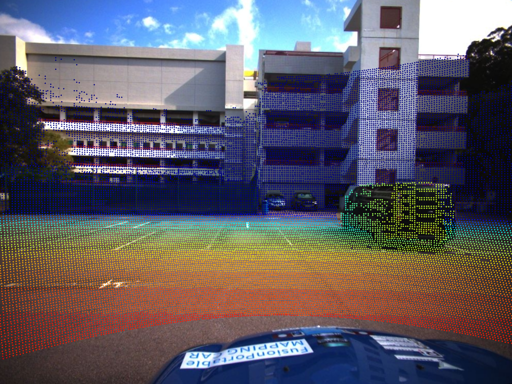

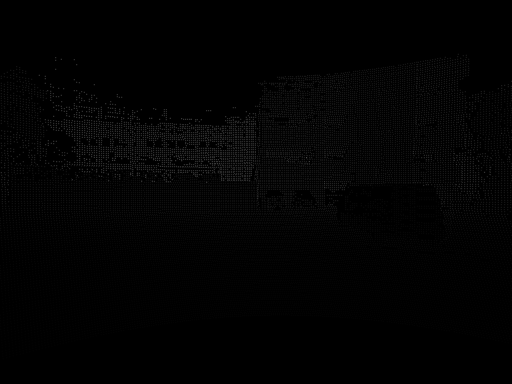

In [6]:
# Description: Generate depth map
import cv2
import open3d
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

cmap = plt.get_cmap('jet')
cmap_colors = cmap(np.linspace(0, 1, 21)) * 255
frame_id = 0

##### Load point cloud and image
pcd_path = os.path.join(kitti360_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
xyz_points = np.asarray(open3d.io.read_point_cloud(pcd_path).points)
if platform == 'vehicle':
  img_path = os.path.join(kitti360_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
  img = cv2.imread(img_path)
  camera = int_ext_loader.sensor_collection['vehicle_frame_left_camera']
else:
  img_path = os.path.join(kitti360_path, 'frame_cam00', 'image/data', '{:06d}.png'.format(frame_id)) # images are already undistorted, but not rectified
  img = cv2.imread(img_path)
  camera = int_ext_loader.sensor_collection['frame_left_camera']

##### Load extrinsics from the tf_graph
T_cam_lidar = int_ext_loader.tf_graph.get_relative_transform(camera.frame_id, 'body_imu')
xyz_points_cam = np.matmul(T_cam_lidar[:3, :3], xyz_points.T).T + T_cam_lidar[:3, 3].T

##### Project point cloud onto the camera frame
for p_C in xyz_points_cam:
  flag, u_C = camera.project(p_C)
  if flag:
    i = int(min(p_C[2], 20.0))
    color = (int(cmap_colors[i, 0]), int(cmap_colors[i, 1]), int(cmap_colors[i, 2]))
    cv2.circle(img, (round(u_C[0]), round(u_C[1])), radius=1, color=color, thickness=-1)
img_pillow = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
display(img_pillow.resize((img_pillow.size[0] // 2, img_pillow.size[1] // 2))) 

##### Project point cloud onto the depth camera frame
depth_img = np.zeros((camera.height, camera.width), dtype=np.uint32)
for p_C in xyz_points_cam:
  flag, u_C = camera.project(p_C)
  if flag:
    depth_img[round(u_C[1])][round(u_C[0])] = np.uint32(p_C[2] * 1000)
img_pillow = Image.fromarray(depth_img)
display(img_pillow.resize((img_pillow.size[0] // 2, img_pillow.size[1] // 2))) 

std::vector<Eigen::Vector3d> with 131072 elements.
Use numpy.asarray() to access data.
std::vector<Eigen::Vector3d> with 131072 elements.
Use numpy.asarray() to access data.


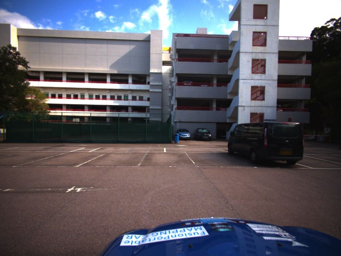

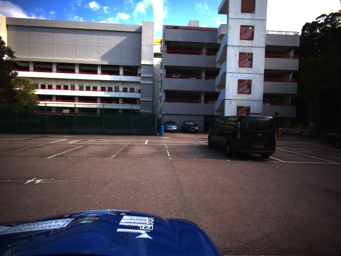

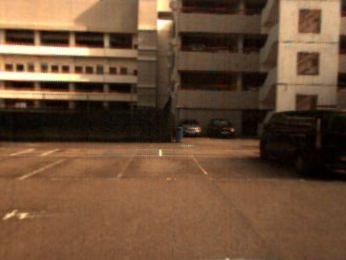

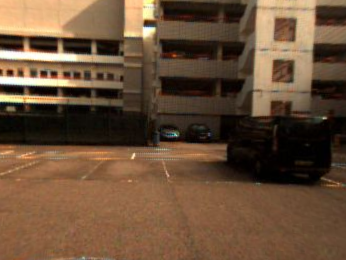

In [7]:
# TEST: visualize data
from PIL import Image
from IPython.display import display
import open3d

frame_id = 0

# Visualize data
pcd_path = os.path.join(kitti360_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

pcd_path = os.path.join(kitti360_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

if platform == 'vehicle':
  img_path = os.path.join(kitti360_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id))
  img = Image.open(img_path)
  img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
  display(img_resize)

  img_path = os.path.join(kitti360_path, 'vehicle_frame_cam01', 'image/data', '{:06d}.png'.format(frame_id))
  img = Image.open(img_path)
  img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
  display(img_resize)
else:
  img_path = os.path.join(kitti360_path, 'frame_cam00', 'image/data', '{:06d}.png'.format(frame_id))
  img = Image.open(img_path)
  img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
  display(img_resize)

  img_path = os.path.join(kitti360_path, 'frame_cam01', 'image/data', '{:06d}.png'.format(frame_id))
  img = Image.open(img_path)
  img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
  display(img_resize)

img_path = os.path.join(kitti360_path, 'event_cam00', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)

img_path = os.path.join(kitti360_path, 'event_cam01', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)

In [9]:
##### TEST: get extrinsics
print(int_ext_loader.tf_graph.get_relative_transform('body_imu', 'ouster00')[:3, :3])
print(int_ext_loader.tf_graph.get_relative_transform('body_imu', 'ouster00')[:3, 3])

[[ 0.99995859  0.00830747  0.00371544]
 [-0.00831236  0.9999646   0.00130257]
 [-0.00370449 -0.0013334   0.99999225]]
[ 0.0359568  -0.01764044  0.03291764]
